<a href="https://colab.research.google.com/github/mlaguna10/MLT_solutions/blob/master/Lab6_MLT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020

# Laboratorio 6

## Integrantes

*   Ramiro Vargas Salas - 201910642
*   Mateo Laguna Guantiva - 201414158


In [1]:
import pandas as pd
import numpy as np
import sys
import random
from pandas_profiling import ProfileReport

import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import applications

from sklearn.metrics import classification_report, confusion_matrix

print('Tensorflow version:', tf.__version__)

Using TensorFlow backend.


Tensorflow version: 2.2.0


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

#1. Comprensión de los datos

Este es un conjunto de datos de 60.000 imágenes de tamaño 28x28 píxeles en formato gris que posee 10 diferentes categorías. 

Categorías: 

0.	T-shirt/top
1.	Trouser
2.	Pullover
3.	Dress
4.	Coat
5.	Sandal
6.	Shirt
7.	Sneaker
8.	Bag
9.	Ankle boot

Tomado de https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


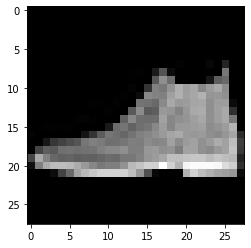

In [4]:
plt.imshow(x_test[0], cmap = 'gray')

In [5]:
x_test[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [6]:
y_train[0]

9

In [7]:
x_train.shape

(60000, 28, 28)

Como se puede observar, cada imagen consiste en un array de arrays de 28 valores númericos que corresponden a la intensidad en la escala de grises desde 0 a 255. En el conjunto train con el mismo índice se puede acceder al label. Para el caso de la primera imagen del conjunto, podemos ver que corresponde a la clase 9 Ankle Boot.

#2. Preparación de los datos

Pasamos a un formato mas manejable para Keras:

In [8]:
from keras.utils import to_categorical
 
x_train = x_train.reshape((60000, 784))
print(type(x_train))
x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)
 
x_test = x_test.reshape((10000, 784))
x_test = x_test.astype('float32') / 255
y_test = to_categorical(y_test)

<class 'numpy.ndarray'>


Separamos conjunto de validación para evitar el sobreentrenamiento

In [9]:
np.random.seed(42)
 
# barajamos el dataset
permutation = np.random.permutation(x_train.shape[0])
x_train = x_train[permutation]
y_train = y_train[permutation]
 
# obtenemos el conjunto de validación
num_val = 10000
x_val = x_train[:num_val]
x_train = x_train[num_val:]
y_val = y_train[:num_val]
y_train = y_train[num_val:]

No se realiza una limpieza de datos dado que el conjunto de datos es muy famoso para quienes inician en el mundo de las redes neuronales convolucionales, al ser pensado para esa población, el conjunto viene bien definido. 

#3-4. Modelamiento y Validación

#Parte A

Creamos el modelo con dos capas de entreda, dos en la capa oculta y una capa de salida con 10 neuronas. Al ver que con estos parámetros ya se obtuvo un muy buen modelo, se descarta la idea de optimizarlos. 

In [10]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(784,))) # 28x28=784
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Utilizamos una funcion para optimizar el modelo "rmsprop" basado en descenso por el gradiente

In [11]:
model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

Entrenamos nuestro modelo con 30 epochs y tamaños de batch de 128

In [12]:
train_log = model.fit(x_train, y_train, 
                      epochs=30, batch_size=128,
                     validation_data=(x_val, y_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 2s 49us/step - loss: 0.5647 - accuracy: 0.7964 - val_loss: 0.5508 - val_accuracy: 0.7896
Epoch 2/30
50000/50000 [==============================] - 2s 44us/step - loss: 0.3939 - accuracy: 0.8546 - val_loss: 0.3878 - val_accuracy: 0.8576
Epoch 3/30
50000/50000 [==============================] - 2s 44us/step - loss: 0.3478 - accuracy: 0.8723 - val_loss: 0.3811 - val_accuracy: 0.8598
Epoch 4/30
50000/50000 [==============================] - 2s 44us/step - loss: 0.3185 - accuracy: 0.8828 - val_loss: 0.3601 - val_accuracy: 0.8681
Epoch 5/30
50000/50000 [==============================] - 2s 44us/step - loss: 0.2981 - accuracy: 0.8889 - val_loss: 0.4118 - val_accuracy: 0.8552
Epoch 6/30
50000/50000 [==============================] - 2s 44us/step - loss: 0.2812 - accuracy: 0.8945 - val_loss: 0.3210 - val_accuracy: 0.8839
Epoch 7/30
50000/50000 [==============================] - 2s 43us/st

Obtenemos los resultados con el conjunto de test

In [13]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(test_accuracy)

10000/10000 [==============================] - 0s 31us/step
0.8677999973297119


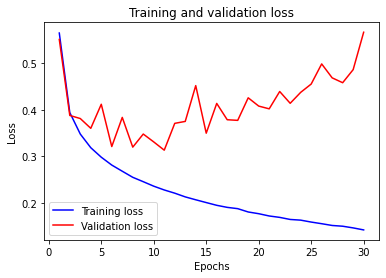

In [14]:
loss = train_log.history['loss']
val_loss = train_log.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

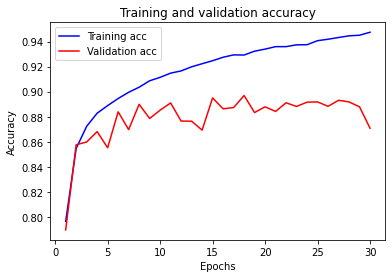

In [15]:
plt.clf()
acc = train_log.history['accuracy']
val_acc = train_log.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Conclusiones parte A

*   En la primera gráfica se puede observar que después del epoch 9 el accuracy alcanza uno de sus valores más altos, pero luego empieza a oscilar. 

*   Tenemos una precisión de 87% que en este caso es buena para el modelo.

*   Dado los resultados se va a limitar el número de epochs a 9 que es cuando el modelo comienza a desmejorar.


In [20]:
train_log = model.fit(x_train, y_train, 
                      epochs=8, batch_size=480,
                     validation_data=(x_val, y_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/8
50000/50000 [==============================] - 1s 28us/step - loss: 0.0896 - accuracy: 0.9653 - val_loss: 0.7175 - val_accuracy: 0.8793
Epoch 2/8
50000/50000 [==============================] - 1s 28us/step - loss: 0.0887 - accuracy: 0.9656 - val_loss: 0.6023 - val_accuracy: 0.8838
Epoch 3/8
50000/50000 [==============================] - 1s 27us/step - loss: 0.0872 - accuracy: 0.9667 - val_loss: 0.5244 - val_accuracy: 0.9009
Epoch 4/8
50000/50000 [==============================] - 1s 28us/step - loss: 0.0858 - accuracy: 0.9675 - val_loss: 0.8235 - val_accuracy: 0.8579
Epoch 5/8
50000/50000 [==============================] - 1s 28us/step - loss: 0.0863 - accuracy: 0.9668 - val_loss: 0.6418 - val_accuracy: 0.8860
Epoch 6/8
50000/50000 [==============================] - 1s 28us/step - loss: 0.0833 - accuracy: 0.9679 - val_loss: 0.5782 - val_accuracy: 0.8937
Epoch 7/8
50000/50000 [==============================] - 1s 28us/step - lo

In [21]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(test_accuracy)

10000/10000 [==============================] - 0s 27us/step
0.8883000016212463


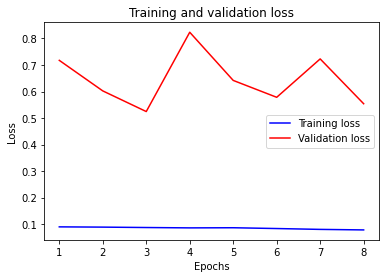

In [22]:
loss = train_log.history['loss']
val_loss = train_log.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

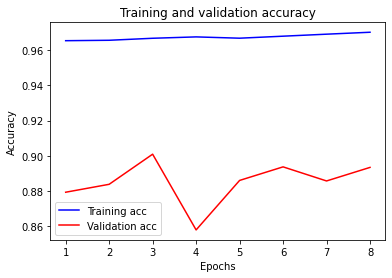

In [23]:
plt.clf()
acc = train_log.history['accuracy']
val_acc = train_log.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Ya observamos comportamiento correcto con el conjunto de Validación y Training continuamos con la predicción del modelo

In [24]:
predictions = model.predict(x_test)
np.argmax(predictions[0])

9

#Parte B

In [25]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [26]:
from keras.utils import to_categorical
 
x_train = x_train.reshape((60000, 784))
print(type(x_train))
x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)
 
x_test = x_test.reshape((10000, 784))
x_test = x_test.astype('float32') / 255
y_test = to_categorical(y_test)

<class 'numpy.ndarray'>


In [27]:
np.random.seed(42)
 
# barajamos el dataset
permutation = np.random.permutation(x_train.shape[0])
x_train = x_train[permutation]
y_train = y_train[permutation]
 
# obtenemos el conjunto de validación
num_val = 10000
x_val = x_train[:num_val]
x_train = x_train[num_val:]
y_val = y_train[:num_val]
y_train = y_train[num_val:]

In [28]:
from keras import models, layers

autoencoder = models.Sequential()
autoencoder.add(layers.Dense(256, activation='relu', input_shape=(784,)))
autoencoder.add(layers.Dense(128, activation='relu'))
autoencoder.add(layers.Dense(64, activation='relu'))
autoencoder.add(layers.Dense(28, activation='relu'))
autoencoder.add(layers.Dense(5, activation='relu'))
autoencoder.add(layers.Dense(10, activation='softmax'))

In [29]:
model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [30]:
train_log = model.fit(x_train, y_train, 
                      epochs=8, batch_size=480,
                     validation_data=(x_val, y_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/8
50000/50000 [==============================] - 2s 30us/step - loss: 0.0858 - accuracy: 0.9693 - val_loss: 0.6141 - val_accuracy: 0.8947
Epoch 2/8
50000/50000 [==============================] - 1s 28us/step - loss: 0.0750 - accuracy: 0.9724 - val_loss: 0.5829 - val_accuracy: 0.8906
Epoch 3/8
50000/50000 [==============================] - 1s 28us/step - loss: 0.0750 - accuracy: 0.9720 - val_loss: 0.6437 - val_accuracy: 0.8829
Epoch 4/8
50000/50000 [==============================] - 1s 28us/step - loss: 0.0719 - accuracy: 0.9728 - val_loss: 0.6073 - val_accuracy: 0.8903
Epoch 5/8
50000/50000 [==============================] - 1s 28us/step - loss: 0.0695 - accuracy: 0.9727 - val_loss: 0.6924 - val_accuracy: 0.8868
Epoch 6/8
50000/50000 [==============================] - 1s 28us/step - loss: 0.0710 - accuracy: 0.9733 - val_loss: 0.6615 - val_accuracy: 0.8925
Epoch 7/8
50000/50000 [==============================] - 1s 28us/step - lo

In [31]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(test_accuracy)

10000/10000 [==============================] - 0s 37us/step
0.879800021648407


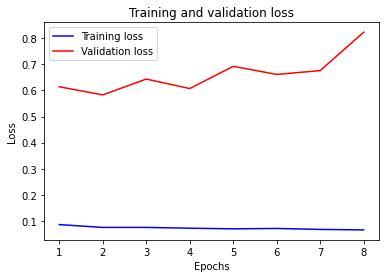

In [32]:
loss = train_log.history['loss']
val_loss = train_log.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

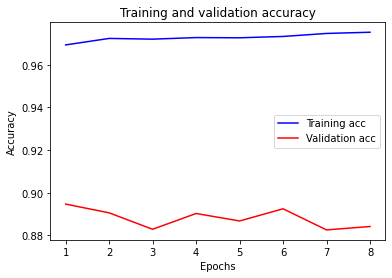

In [33]:
plt.clf()
acc = train_log.history['accuracy']
val_acc = train_log.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Resultados Observados


1.   Al añadir más capas y reducir el número de neuronas se observa que el modelo se va acomodando cada vez mas a los resultados del grupo de training bajando la pérdida.
2.   Esto no necesariamente va a incrementar la precisión de nuestro modelo, con lo que tenemos que llegar a un punto de equilibrio


In [45]:
x_test[:10].shape

(10, 784)

In [47]:
predicted = model.predict(x_test[:10])

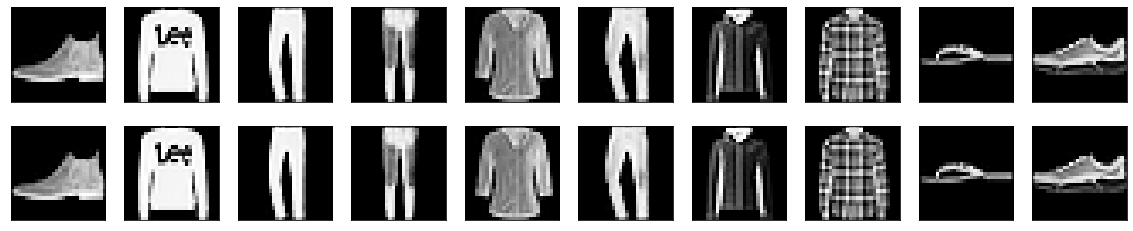

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([x_test[:10], x_test[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Observamos que la imagen después de manipularla está igual, tuvimos que hacer un resizing al modelo para poder vizualizar las imágenes.

#Parte C

In [49]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [50]:
x_train = x_train / 255
x_test = x_test / 255

In [51]:
np.random.seed(42)
 
# barajamos el dataset
permutation = np.random.permutation(x_train.shape[0])
x_train = x_train[permutation]
y_train = y_train[permutation]
 
# obtenemos el conjunto de validación sobre 10%
num_val = 1000
x_val = x_train[:num_val]
x_train = x_train[num_val:]
y_val = y_train[:num_val]
y_train = y_train[num_val:]

Función para agregar ruido

In [52]:
def noising_image(data, noise_factor):
  noise_dataset = []
  for img in data:
    noisy_image = img + noise_factor * np.random.randn(*img.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    noise_dataset.append(noisy_image)
  
  noise_dataset = np.array(noise_dataset)
  return noise_dataset

In [53]:
x_train_noise = noising_image(x_train, 0.2)
x_val_noise = noising_image(x_val, 0.2)
x_test_noise = noising_image(x_test, 0.2)

In [54]:
from keras import models, layers

autoencoder = Sequential()

#Encoder
autoencoder.add(Conv2D(filters=16, kernel_size=3, strides=2, padding="same", input_shape=(28, 28, 1)))
autoencoder.add(Conv2D(filters=8, kernel_size=3, strides=2, padding="same"))

#Encoded image
autoencoder.add(Conv2D(filters=8, kernel_size=3, strides=1, padding="same"))

#Decoder
autoencoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same"))
autoencoder.add(Conv2DTranspose(filters=1, kernel_size=3, strides=2, activation='sigmoid', padding="same"))

In [55]:
autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001),metrics = ['accuracy'])
autoencoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         145       
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [56]:
train_log=autoencoder.fit(x_train_noise.reshape(-1, 28, 28, 1),          
                x_train.reshape(-1, 28, 28, 1), 
                epochs=10, 
                batch_size=200, 
                validation_data=(
                    x_val_noise.reshape(-1, 28, 28, 1), 
                    x_val.reshape(-1, 28, 28, 1)
                    )
                )

Train on 59000 samples, validate on 1000 samples
Epoch 1/10
59000/59000 [==============================] - 13s 215us/step - loss: 0.3960 - accuracy: 0.4965 - val_loss: 0.3147 - val_accuracy: 0.5109
Epoch 2/10
59000/59000 [==============================] - 12s 211us/step - loss: 0.3086 - accuracy: 0.5084 - val_loss: 0.3014 - val_accuracy: 0.5118
Epoch 3/10
59000/59000 [==============================] - 12s 211us/step - loss: 0.3005 - accuracy: 0.5089 - val_loss: 0.2960 - val_accuracy: 0.5121
Epoch 4/10
59000/59000 [==============================] - 12s 210us/step - loss: 0.2960 - accuracy: 0.5092 - val_loss: 0.2921 - val_accuracy: 0.5124
Epoch 5/10
59000/59000 [==============================] - 12s 210us/step - loss: 0.2931 - accuracy: 0.5094 - val_loss: 0.2900 - val_accuracy: 0.5125
Epoch 6/10
59000/59000 [==============================] - 13s 213us/step - loss: 0.2915 - accuracy: 0.5095 - val_loss: 0.2887 - val_accuracy: 0.5126
Epoch 7/10
59000/59000 [==============================] -

In [58]:
predicted = autoencoder.predict(x_test_noise[:10].reshape(-1, 28, 28, 1))

In [59]:
evaluation = autoencoder.evaluate(x_test_noise.reshape(-1, 28, 28, 1), x_test.reshape(-1, 28, 28, 1))
print(evaluation)

10000/10000 [==============================] - 1s 122us/step
[0.2910120194911957, 0.5074512958526611]


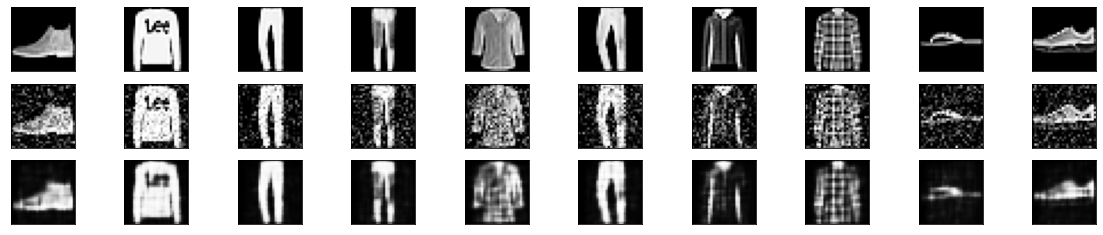

In [60]:
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([x_test[:10], x_test_noise[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

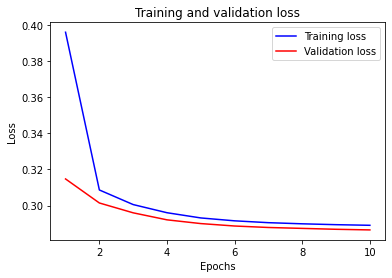

In [61]:
loss = train_log.history['loss']
val_loss = train_log.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

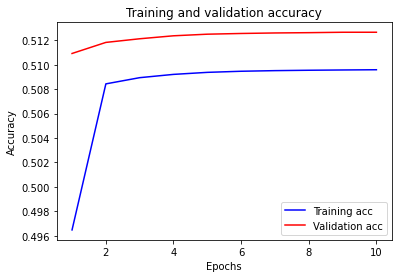

In [62]:
plt.clf()
acc = train_log.history['accuracy']
val_acc = train_log.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Conclusiones



1.   Para el modelo A se obtuvo mejores datos de precisión.
2.   Para el modelo B se obtuvo mejores resultados en la pérdida del modelo que estuvo mas conforme con los datos de entrenamiento.
3.   Para el modelo C no se tuvo buenos resultados, pero pese a que se distorcionaron las imágenes y sólo se entrenó con el 10% de los datos se obtuvo una presicion del 50%. 